In [8]:
# import cv2
# import numpy as np

# def preprocess_image(image):
#     # Check if the image is grayscale, convert to BGR if necessary
#     if len(image.shape) == 2:
#         image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
#     # Convert the image to grayscale
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
#     # Apply pixel-wise adaptive filtering using filter2D
#     kernel = np.ones((5, 5), np.float32) / 25
#     filtered = cv2.filter2D(gray, -1, kernel)
    
#     return filtered

In [21]:
import cv2
import numpy as np



def remove_shadows(image):
    # convert to LAB color space
    # print('image', image.dtype)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        

    # split the LAB channels
    l, a, b = cv2.split(lab)
    
    # apply the Retinex algorithm to the L channel
    # set the gain to 128 for best results
    l = cv2.createCLAHE(clipLimit=1, tileGridSize=(3,3)).apply(l)
    # merge the LAB channels back together
    lab = cv2.merge((l,a,b))

    # convert back to BGR color space
    result = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return result


def preprocess_image(img):
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U) # convert to 8-bit
    img = cv2.GaussianBlur(img, (3, 3), 0)
    # Apply Gaussian blur with kernel size of 3 
    img = remove_shadows(img)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    # # Apply Canny edge detector with minVal of 100 and maxVal of 200
    img = cv2.Canny(img, 50, 200)
    return img

In [30]:
def detect_fingertips(image):
    # Compute edges using the Sobel operator
    edges = cv2.Sobel(image, cv2.CV_8U, 1, 1, ksize=3)
    
    # Perform morphological processing (dilation)
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel)
    
    # Perform image fill operation
    _, filled = cv2.threshold(dilated, 0, 255, cv2.THRESH_BINARY)
    
    # Compute circular Hough transform
    circles = cv2.HoughCircles(filled, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                               param1=50, param2=30, minRadius=10, maxRadius=50)
    
    # If circles are detected, extract fingertip coordinates
    if circles is not None:
        circles = np.round(circles[0, :]).astype(int)
        fingertips = circles[:, :2]
    else:
        fingertips = []
    
    return fingertips

def count_fingers(image, fingertips):
    # Check if fingertips array is empty
    if len(fingertips) == 0:
        return 0

    # Check if the image is grayscale, convert to BGR if necessary
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Perform HoughLinesP to detect lines
    lines = cv2.HoughLinesP(gray, rho=1, theta=np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)
    
    # If lines are detected, compare with fingertip coordinates to identify fingers
    if lines is not None:
        lines = lines[:, 0, :]
        fingers = []
        
        for line in lines:
            x1, y1, x2, y2 = line
            # Reshape the fingertips array to have two columns
            fingertips_array = np.reshape(fingertips, (-1, 2))
            # Check if the line is close to any fingertip coordinates
            distances = np.sqrt(np.power(fingertips_array[:, 0] - x1, 2) +
                                np.power(fingertips_array[:, 1] - y1, 2))
            closest_fingertip = np.argmin(distances)
            
            if distances[closest_fingertip] < 20:
                fingers.append(fingertips[closest_fingertip])
        
        num_fingers = len(fingers)
    else:
        num_fingers = 0
    
    return num_fingers

In [31]:
# Load the hand image
img = cv2.imread('3_men (1).JPG')

img_size=(200,200)

image = cv2.resize(img, img_size)

# Preprocess the image
preprocessed = preprocess_image(image)

# Detect fingertips
fingertips = detect_fingertips(preprocessed)

# Count the number of fingers
num_fingers = count_fingers(preprocessed, fingertips)



0


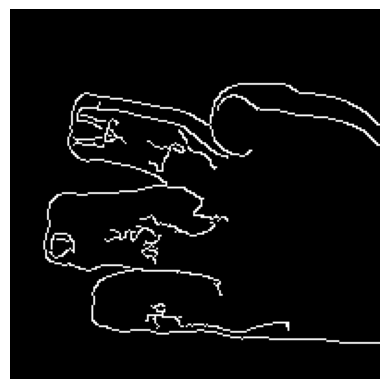

In [32]:
import matplotlib.pyplot as plt

# ...

# Display the results
# cv2.putText(preprocessed, f'Fingers: {num_fingers}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX,
#             1, (0, 0, 255), 2)

print(num_fingers)

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(preprocessed, cv2.COLOR_BGR2RGB)

# Show the image using matplotlib
plt.imshow(image_rgb)
plt.axis('off')
plt.show()
